# Running Simulations

## Introduction

This notebook demonstrates how to use the CT simulation tools included in the [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms) repo and how these tools can be used to build pediatric IQ phantom datasets. These tools were used to generate the [pediatricIQphantoms dataset](https://zenodo.org/doi/10.5281/zenodo.10064035) using the [pediatricIQphantoms.toml](https://github.com/DIDSR/pediatricIQphantoms/blob/main/configs/pediatricIQphantoms.toml) configuration file.

This tutorial will introduce:
1. [individual simulations](#Individual-Simulations) - this section discusses key technique parameters and how to change them
2. [batch mode simulation](#Batch-Mode-Simulations) - this section introduces how to systematically iterate through parameters to build a dataset
3. [command line tool](#Command-Line-Interface-Tool:-make_phantoms) this section combines themes from the previous sections into a command line tool using configuration files consisting of the same technique parameters discussed in sections [individual simulations](#Individual-Simulations) and [batch mode simulation](#Batch-Mode-Simulations)

## Individual Simulations

The main tool for running individual simulations is the [CTobj class](https://pediatriciqphantoms.readthedocs.io/en/latest/function_reference.html#pediatricIQphantoms.CTobj) which both holds the key parameters for running and describing the scan as well as having methods to [run the scan](https://pediatriciqphantoms.readthedocs.io/en/latest/function_reference.html#pediatricIQphantoms.CTobj.run) and [write the output to dicom](https://pediatriciqphantoms.readthedocs.io/en/latest/function_reference.html#pediatricIQphantoms.CTobj.write_to_dicom)

As shown in the Class signature above, most attributes have default values provided, these values correspond to a Siemen's Definition AS+ scanner as described in [Zeng et al 2022](https://aapm.onlinelibrary.wiley.com/doi/pdf/10.1002/mp.15430). Thus it can be defined and `run()` with no further initialization attributes. For this example we'll specify the CTP404 phantom and keep all other defaults.

In [1]:
!pip install seaborn -q
!pip install matplotlib -q

In [2]:
from pediatricIQphantoms import CTobj
ct = CTobj('CTP404')
ct

<class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm CTP404 I0: 300000.0

You can also experiment with changing the lesion size for different phantoms, note CCT189 expects a length 4 list since the lesions are each different sizes, whereas CTP404 takes a single values since all inserts are equally sized. See [documentation](https://pediatriciqphantoms.readthedocs.io/en/latest/function_reference.html#pediatricIQphantoms.run_batch_sim) for details.
```python
import numpy as np
lesion_diameter = np.array([0.015, 0.025, 0.035, 0.05])*2 # in order of 14 HU, 7 HU, 5 HU, and 3 HU
# lesion_diameter = [3, 5, 7, 10]; # in mm
ct.lesion_diameter = lesion_diameter
```

In [3]:
ct.run()

<class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm CTP404 I0: 300000.0
Recon: (1, 512, 512) 34.0 cm FOV
Projections: (900, 580)

You can access the reconstruction and projection data as numpy arrays via the object attributes:

In [4]:
type(ct.recon), ct.recon.shape, type(ct.projections), ct.projections.shape

(numpy.ndarray, (1, 512, 512), numpy.ndarray, (900, 580))

In [5]:
fname = ct.write_to_dicom('test.dcm')

import pydicom
dcm = pydicom.read_file(fname[0])
dcm.PatientName

'20.0 cm CTP404'

In [6]:
!pip install ipywidgets -q

In [7]:
import matplotlib.pyplot as plt

from utils import ctshow

The [`CTobj`](https://pediatriciqphantoms.readthedocs.io/en/latest/function_reference.html#pediatricIQphantoms.CTobj) ooject also holds the `groundtruth` attribute following the reconstruction

Text(0.5, 1.0, 'Ground Truth')

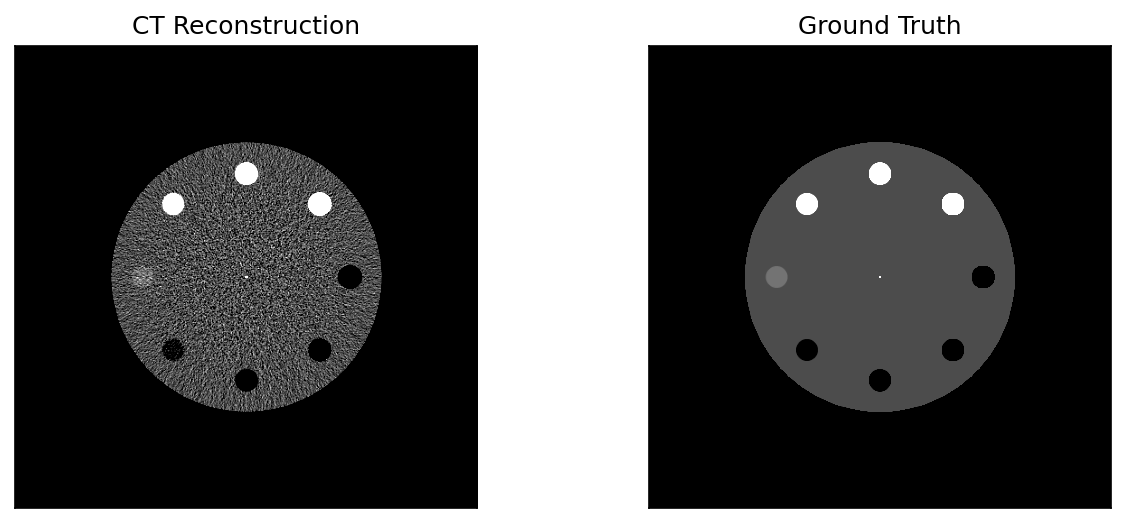

In [8]:
plt.figure(figsize=(10,4), dpi=150)
plt.subplot(1,2,1)
win, lvl = 100, 20
display_settings = (win, lvl)
ctshow(ct.recon[0], display_settings)
plt.title('CT Reconstruction')
plt.subplot(1,2,2)
ctshow(ct.groundtruth, display_settings)
plt.title('Ground Truth')

The `CTobj` ooject also holds the `projections`

Text(0, 0.5, 'detector index')

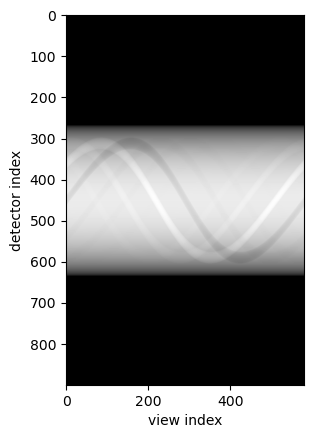

In [9]:
import numpy as np
plt.imshow(-np.log(ct.projections), cmap='gray')
plt.xlabel('view index')
plt.ylabel('detector index')

### Different Phantoms

Here we demonstrate the different phantoms available by defining three CTobj objects each with different phantoms

In [10]:
ctp404 = CTobj('CTP404').run()
mital_lcd = CTobj('MITA-LCD', I0=3e7).run()# <-- higher dose to show low contrast lesions
uniform = CTobj('uniform').run()

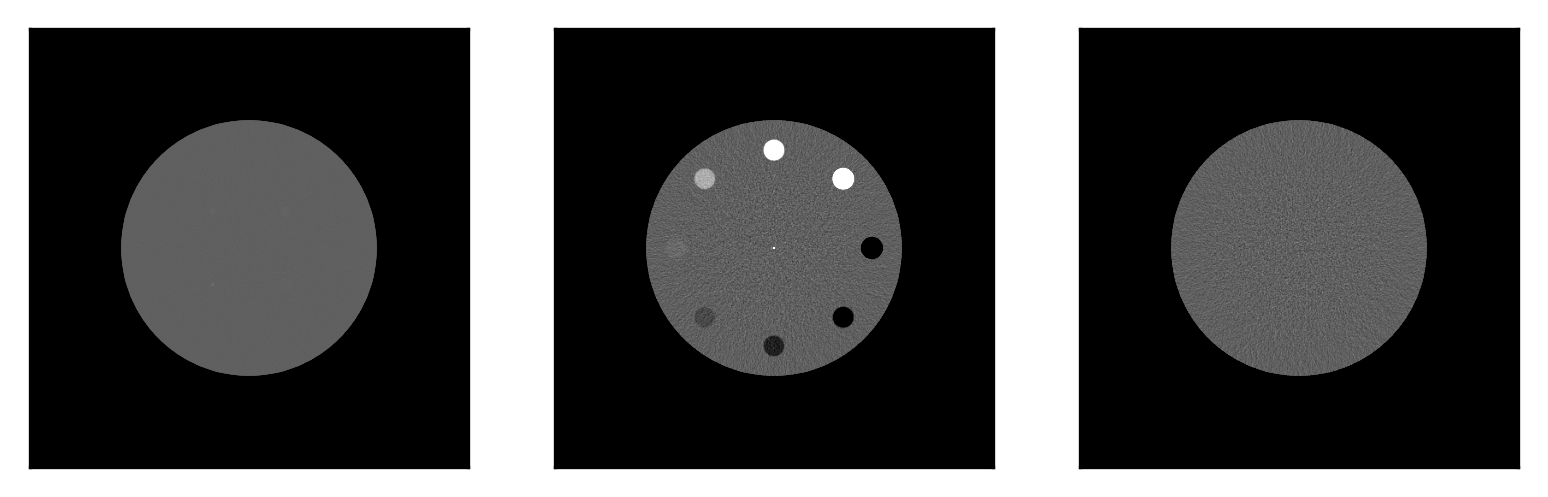

In [11]:
plt.figure(dpi=300)

display_settings =  'soft tissues'

plt.subplot(1,3,1)
ctshow(mital_lcd.recon, display_settings)

plt.subplot(1,3,2)
ctshow(ctp404.recon)

plt.subplot(1,3,3)
ctshow(uniform.recon, display_settings)
plt.show()

### Different Dose Levels

Next let's run a simulation using the `Uniform` phantom but scanned at different dose levels to see how noise trends compare with increasing dose level.

Due to the relationship of $noise \propto \sqrt{1/N}$, thus we expect to see **1/2 the noise at 4x dose**

In [12]:
import numpy as np
max_dose = 1e5 # photons per detector see MIRT https://github.com/JeffFessler/mirt
dose_levels = np.linspace(1, 4, 3)
print(dose_levels)
doses = dose_levels*max_dose
res_list = [CTobj('Uniform', I0=I0, nsims=2).run() for I0 in doses]

[1.  2.5 4. ]




















In [13]:
res_list

[<class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm Uniform I0: 100000.0
 Recon: (2, 512, 512) 34.0 cm FOV
 Projections: (900, 580),
 <class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm Uniform I0: 250000.0
 Recon: (2, 512, 512) 34.0 cm FOV
 Projections: (900, 580),
 <class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm Uniform I0: 400000.0
 Recon: (2, 512, 512) 34.0 cm FOV
 Projections: (900, 580)]

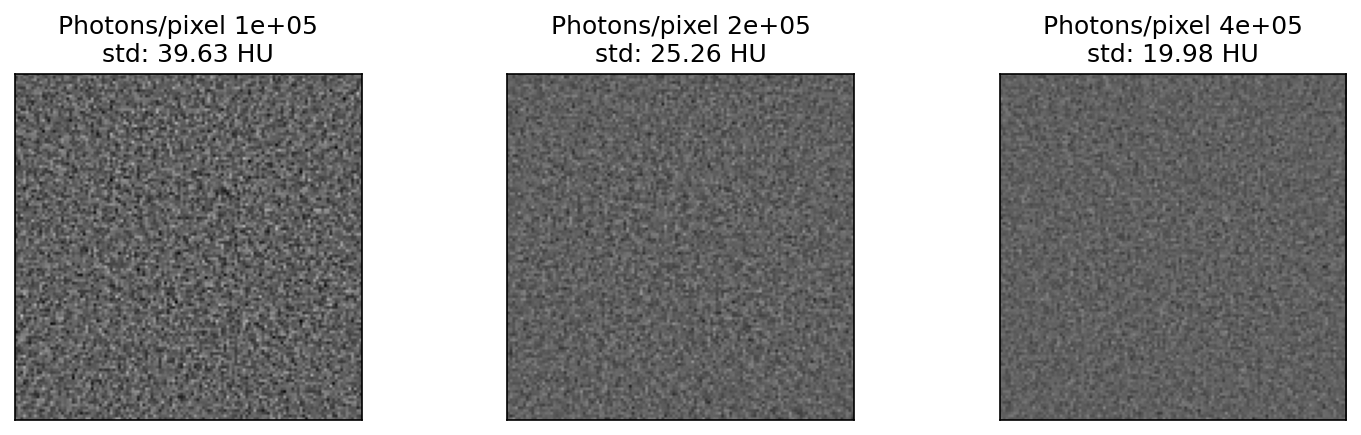

In [14]:
nres = 3
std_noise = []
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    nz, nx, ny = res.recon.shape
    if idx//3 == 0:
        plt.subplot(1, nres, idx+1)
        ctshow(res.recon[0, nx//2-nx//8:nx//2+nx//8, nx//2-nx//8:nx//2+nx//8], 'soft tissues')
    nz, nx, ny = res.recon.shape
    std_noise.append(res.recon[0, nx//2-nx//8:nx//2+nx//8, nx//2-nx//8:nx//2+nx//8].std())
    plt.title(f'Photons/pixel {doses[idx]:1.1g}\nstd: {std_noise[idx]:2.2f} HU')

Text(0.5, 0, 'Dose Level [%]')

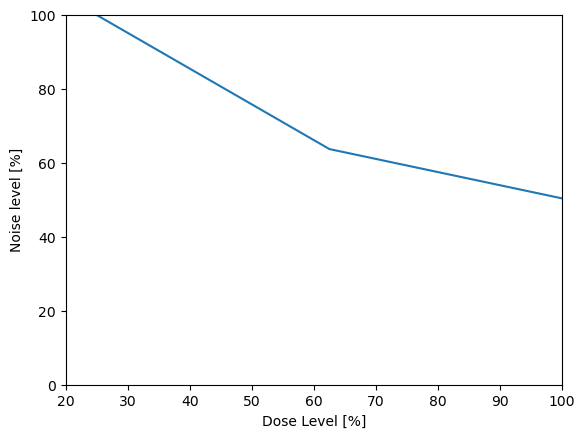

In [15]:
rel_doses = doses/doses.max()*100
std_noise = np.array(std_noise)
rel_noise = std_noise/std_noise.max()*100
plt.plot(rel_doses, rel_noise)
plt.xlim([20, 100])
plt.ylim([0, 100])
plt.ylabel('Noise level [%]')
plt.xlabel('Dose Level [%]')

These figures and plots confirm that the [MIRT simulations](https://github.com/JeffFessler/mirt) are performing as expected in terms of dose-noise relationships.

Below shows how we can write out to DICOM and then the next example explores changing recon kernels.

In [16]:
from pathlib import Path
writedir=Path('data/test')
fnames=[]
for res in res_list:
    fname = res.write_to_dicom(writedir / f'{res.seriesname}.dcm')
    fnames += fname
len(fnames)

6

### Recon Type

In MIRT convolution kernels are specified as `<window function>,<cutoff frequency mm>` for example a typical sharp kernel can be defined as 'hanning,2.05' where a [Hann window](https://en.wikipedia.org/wiki/Hann_function) with a cuffoff ([MTF](https://www.sciencedirect.com/topics/physics-and-astronomy/modulation-transfer-function#:~:text=The%20modulation%20transfer%20function%20(MTF,gets%20transferred%20to%20the%20image.)=0) frequency of 2.05 mm. The table below provides a few Siemen's equivalent kernels based upon matching 50% and 10% MTF cutoffs ([Zeng et al 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430)).

| Description | MIRT         | Siemen's Equivalent |
|:-----------:|--------------|---------------------|
| Sharp       | hanning,2.05 | D45                 |
| Smooth      | hanning,0.85 | B30               

The following experiment runs simulations on increasingly higher cutoff frequency kernels ranging from smooth to sharp.  |

In [17]:
cutoff_freq = [0.5, 0.85, 2.05]

res_list = [CTobj('MITA-LCD', I0=1e6, fbp_kernel=f'hanning,{freq:1.2f}').run() for freq in cutoff_freq]    

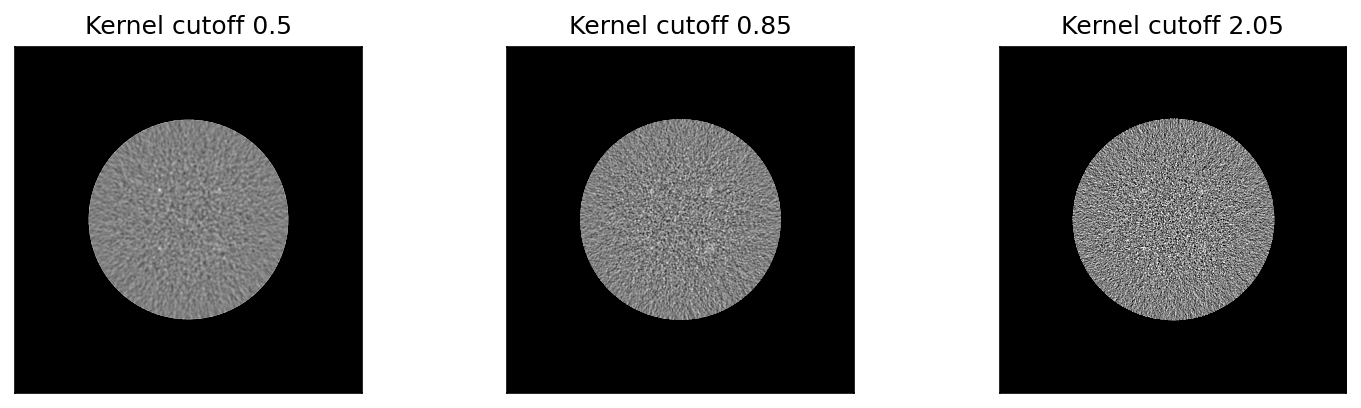

In [18]:
nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, (40, 0))
    plt.title(f'Kernel cutoff {cutoff_freq[idx]}')

### Phantom Size and FOV

Finally let's see how noise texture changes as a result of imaging different sized phantoms with body fitting field of views (FOV)s.

In [19]:
phantom_diameters = [112, 185, 292]

res_list = [CTobj('MITA-LCD', I0=1e6, patient_diameter=d).run() for d in phantom_diameters]   

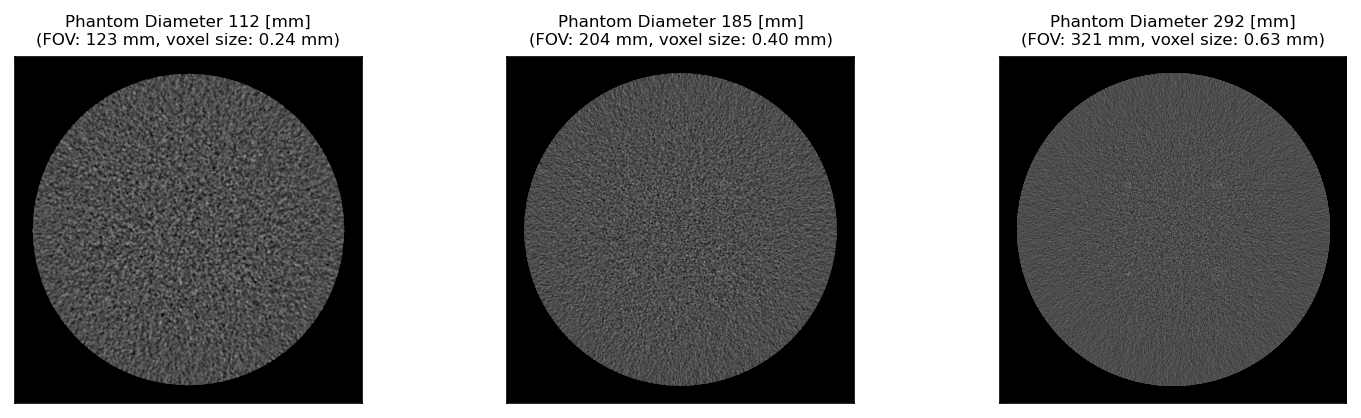

In [20]:
fov = np.array(phantom_diameters)*1.1 # in mm
dx = fov/res.recon.shape[-1]

nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, 'liver')
    plt.title(f'Phantom Diameter {phantom_diameters[idx]} [mm]\n(FOV: {fov[idx]:2.0f} mm, voxel size: {dx[idx]:2.2f} mm)', fontsize=8)

By default when FOV is not specified, it defaults to a body fitting 1.1x the phantom diameter. Note how FOV changes the relative pixel size

## Batch Mode Simulations

The following introduces how to interactively construct batch simulations in a python environment using [run_batch_sim](https://github.com/DIDSR/pediatricIQphantoms/blob/4d3eedd4831ca472b9e76776f4e78ef4a04af430/src/pediatricIQphantoms/make_phantoms.py#L178)

In [21]:
from pediatricIQphantoms import run_batch_sim

Batch mode can be run by either entering in parameter lists for `model`, `diameter`, or `dose_level`

In [22]:
metadata = run_batch_sim(image_directory='data/interactive_batch', dose_level=[0.1, 0.25, 0.5, 1], verbose=False);

/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/notebooks/data/interactive_batch
MITA-LCD Simulation series 0/1
































In [23]:
metadata.head()

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
0,20.0 cm MITA-LCD,000,30000.0 photons 20.0 cm MITA-LCD 10% dose fbp D45,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
1,20.0 cm MITA-LCD,000,75000.0 photons 20.0 cm MITA-LCD 25% dose fbp D45,1,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),25,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
2,20.0 cm MITA-LCD,000,150000.0 photons 20.0 cm MITA-LCD 50% dose fbp...,2,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),50,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
3,20.0 cm MITA-LCD,000,300000.0 photons 20.0 cm MITA-LCD 100% dose fb...,3,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
4,20.0 cm MITA-LCD,000,300000.0 photons 20.0 cm MITA-LCD 100% dose fb...,3,noise free,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),None,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...


Alternatively, you can load in a config file and change it as needed and then input to `run_batch_sim` using the [`**` operator](https://realpython.com/python-kwargs-and-args/)

In [24]:
import tomli
with open('sample_config_file.toml', 'rb') as f:
    config_file = tomli.load(f)
config_file

{'simulation': [{'image_directory': 'results/test',
   'model': ['MITA-LCD', 'CTP404'],
   'diameter': [112, 292],
   'reference_diameter': 200,
   'framework': 'MIRT',
   'nsims': 2,
   'aec_on': True,
   'add_noise': True,
   'full_dose': 300000.0,
   'dose_level': [0.25, 1.0],
   'sid': 595,
   'sdd': 1085.6,
   'ndetectors': 880,
   'nangles': 100,
   'detector_size': 1,
   'detector_offset': 1.25,
   'fov': 340,
   'matrix_size': 256,
   'fbp_kernel': 'hanning,2.05'}]}

In [25]:
config_file.keys(), len(config_file['simulation'])

(dict_keys(['simulation']), 1)

Note: the toml config files are structured to allow multiple simulations with updating select parameters in each simulation, see [Documentation/Usage](https://pediatriciqphantoms.readthedocs.io/en/latest/usage.html) for more details.

This for this example, we want to take the first simulation since `run_batch_sim` expects only flat dictionaries, str, float, and int arguments.

In [26]:
config = config_file['simulation'][0]
config

{'image_directory': 'results/test',
 'model': ['MITA-LCD', 'CTP404'],
 'diameter': [112, 292],
 'reference_diameter': 200,
 'framework': 'MIRT',
 'nsims': 2,
 'aec_on': True,
 'add_noise': True,
 'full_dose': 300000.0,
 'dose_level': [0.25, 1.0],
 'sid': 595,
 'sdd': 1085.6,
 'ndetectors': 880,
 'nangles': 100,
 'detector_size': 1,
 'detector_offset': 1.25,
 'fov': 340,
 'matrix_size': 256,
 'fbp_kernel': 'hanning,2.05'}

In [27]:
config['image_directory'] = 'data/interactive_batch'
config['dose_level'] = [0.1, 0.25, 0.5, 1]
metadata = run_batch_sim(verbose=False, **config)

/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/notebooks/data/interactive_batch
MITA-LCD Simulation series 0/2




























































CTP404 Simulation series 1/2






























































In [28]:
metadata.head()

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
0,11.2 cm MITA-LCD,000,30000.0 photons 11.2 cm MITA-LCD 10% dose fbp D45,0,simulation,11.2,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
1,11.2 cm MITA-LCD,000,30000.0 photons 11.2 cm MITA-LCD 10% dose fbp D45,0,simulation,11.2,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
2,11.2 cm MITA-LCD,000,75000.0 photons 11.2 cm MITA-LCD 25% dose fbp D45,1,simulation,11.2,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),25,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
3,11.2 cm MITA-LCD,000,75000.0 photons 11.2 cm MITA-LCD 25% dose fbp D45,1,simulation,11.2,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),25,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
4,11.2 cm MITA-LCD,000,150000.0 photons 11.2 cm MITA-LCD 50% dose fbp...,2,simulation,11.2,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),50,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...


## Command Line Interface Tool: `make_phantoms`

Finally, datasets can be made in batch mode using the command line tool [`make_phantoms`](https://github.com/DIDSR/pediatricIQphantoms/blob/main/src/pediatricIQphantoms/make_phantoms.py#L390) that should be available globally in your terminal after pip [installing](https://github.com/DIDSR/pediatricIQphantoms?tab=readme-ov-file#start-here) the `pediatricIQphantoms` package.

In [29]:
!make_phantoms -help

usage: make_phantoms [-h] [config]

Make Pediatric IQ Phantoms: command line interface

positional arguments:
  config      input is a configuration .toml file containing simulation
              parameters (see configs/defaults.toml as an example)

options:
  -h, --help  show this help message and exit


For this example we will use [sample_config_file.toml](sample_config_file.toml) as quick example

In [30]:
!cat sample_config_file.toml

# test.toml
[[simulation]]

# directories
image_directory = "results/test"
# phantoms
model = ['MITA-LCD', 'CTP404'] # <-- current options include ['CTP404', 'MITA-LCD', 'UNIFORM']
diameter = [112, 292] # <-- units in mm
reference_diameter = 200 # <-- diameter in mm of the real phantom for comparison

# acquisition
framework = "MIRT" # CT simulation framework options include ['MIRT'] <https://github.com/JeffFessler/mirt>
nsims = 2 # <-- number of simulations to perform with different noise instantiations
aec_on = true # (aec built in to ped xcat) <-- 'aec' = automatic exposure control, when `true`, it ensures constant noise levels for all `patient_diameters` (see `reference_dose_level` for more info)
add_noise = true # <-- if true adds Poisson noise, noise magnitude set by `reference_dose_level`, noise texture set by reconstructed field of view (cuttently fov = 110# patient_diameter) 
full_dose = 3e5 # <-- units of photons per pixel
dose_level = [0.25, 1.00] # <-- units of photons, thi

In [31]:
!make_phantoms sample_config_file.toml

/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/notebooks/results/test
MITA-LCD Simulation series 0/2




The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
lesion_diameter =

   0.015000   0.025000   0.035000   0.050000

ct_sim, simulation: [1/2]
ct_sim, simulation: [2/2]






The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Scie

## Conclusions

In this notebook we walked through how to run [individual simulations](#Individual-Simulations) and [batched simulations](#Batch-Mode-Simulations) interactively as well as how to run and modify configuration files to be run noninteractively using the command line interface.

**Next** see the notebook on [viewing the simulation images](./01_viewing_images.ipynb) or use the simulations to [evaluate pediatric denoising generalizability](./02_pediatric_denoising_evaluation.ipynb).